In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from joblib import Memory

memory = Memory()

In [2]:
@memory.cache
def load_df(path):
    df = pd.read_csv(path)
    # df = df.sort_values(by=["species", "Model", "threshold"])

    return df


df = load_df("data/iwildcam_2022_results_v22_combined.csv")
n_sites = df["location"].nunique()

ci = 95
eps = 0.02
model_labels = {
    "BP": "MacKenzie et al. (2002)",
    "BP_FP": "Royle and Link (2006)",
    "COP": "Pautrel et al. (2024)",
    "NAIVE": "Naive",
}

# set to None to use each respective model or "BP" to use non-false-positive model
# gt_model = None
gt_model = "BP"

In [3]:
# df = df[df["implementation"] == "R"]
df = df[df["implementation"] == "NumPyro"]
df = df[df["sucess"]]

df = df[df["classifier"] == "cameratrapai"]
df = df[df["site_covs"] == "elevation,tree_coverfraction"]
df = df[df["obs_covs"] == "hours_since_sunrise,hours_since_sunset"]
df = df[~df["naive_fp_prior"]]

In [4]:
df

location  Predicted  sucess    classifier  \
2394           3   0.190476    True  cameratrapai   
2395           8   0.190476    True  cameratrapai   
2396           9   0.190476    True  cameratrapai   
2397          14   0.190476    True  cameratrapai   
2398          45   0.190476    True  cameratrapai   
...          ...        ...     ...           ...   
461533       519   0.015651    True  cameratrapai   
461534       526   0.015622    True  cameratrapai   
461535       529   0.015114    True  cameratrapai   
461536       531   0.014312    True  cameratrapai   
461537       547   0.020264    True  cameratrapai   

                           site_covs                                obs_covs  \
2394    elevation,tree_coverfraction  hours_since_sunrise,hours_since_sunset   
2395    elevation,tree_coverfraction  hours_since_sunrise,hours_since_sunset   
2396    elevation,tree_coverfraction  hours_since_sunrise,hours_since_sunset   
2397    elevation,tree_coverfraction  hours_since_sunrise,hours_since_sunset   
2398    elevation,tree_coverfraction  hours_since_sunrise,hours_since_sunset   
...                              ...                                     ...   
461533  elevation,tree_coverfraction  hours_since_sunrise,hours_since_sunset   
461534  elevation,tree_coverfraction  hours_since_sunrise,hours_since_sunset   
461535  elevation,tree_coverfraction  hours_since_sunrise,hours_since_sunset   
461536  elevation,tree_coverfraction  hours_since_sunrise,hours_since_sunset   
461537  elevation,tree_coverfraction  hours_since_sunrise,hours_since_sunset   

       implementation  naive_fp_prior  naive_false_positive_prob  \
2394          NumPyro           False                        NaN   
2395          NumPyro           False                        NaN   
2396          NumPyro           False                        NaN   
2397          NumPyro           False                        NaN   
2398          NumPyro           False                        NaN   
...               ...             ...                        ...   
461533        NumPyro           False                        0.0   
461534        NumPyro           False                        0.0   
461535        NumPyro           False                        0.0   
461536        NumPyro           False                        0.0   
461537        NumPyro           False                        0.0   

        naive_false_positive_prob_std  ...  cov_det_intercept_hdpi_lower  \
2394                              NaN  ...                           NaN   
2395                              NaN  ...                           NaN   
2396                              NaN  ...                           NaN   
2397                              NaN  ...                           NaN   
2398                              NaN  ...                           NaN   
...                               ...  ...                           ...   
461533                            0.0  ...                     -1.990338   
461534                            0.0  ...                     -1.990338   
461535                            0.0  ...                     -1.990338   
461536                            0.0  ...                     -1.990338   
461537                            0.0  ...                     -1.990338   

        cov_det_hours_since_sunrise_hdpi_lower  \
2394                                       NaN   
2395                                       NaN   
2396                                       NaN   
2397                                       NaN   
2398                                       NaN   
...                                        ...   
461533                               -1.967027   
461534                               -1.967027   
461535                               -1.967027   
461536                               -1.967027   
461537                               -1.967027   

       cov_det_hours_since_sunset_hdpi_lower cov_state_intercept_hdpi_upper  \


In [5]:
# df[df["threshold_type"] == "sampled"].plot.scatter(x="threshold", y="naive_false_positive_rate")
# df[(~df["naive_false_positive_rate"].isna()) & (df["threshold_type"] == "sampled")]["naive_false_positive_rate"].mean()

# df.iloc[df["naive_false_positive_rate"].argmin()].to_dict()

In [6]:
# fig, ax = plt.subplots(1, 1, figsize=(8, 6))
# for i, model in enumerate(df["Model"].unique()):
#     mask_estimate = (df["Model"] == model) & (df["threshold_type"] == "calibrated") & (df["implementation"] == "NumPyro")
#     mask_gt = (df["Model"] == gt_model) & (df["threshold_type"] == "gt")
#     mean_abs_error_fpnoprior = (df[mask_estimate & ~df["naive_fp_prior"]]["Predicted"] - df[mask_gt & ~df["naive_fp_prior"]]["Predicted"]).abs().mean()
#     mean_abs_error_naivefpprior = (df[mask_estimate & df["naive_fp_prior"]]["Predicted"] - df[mask_gt & df["naive_fp_prior"]]["Predicted"]).abs().mean()

#     print((df[mask_estimate & ~df["naive_fp_prior"]]))

#     print(mean_abs_error_fpnoprior, mean_abs_error_naivefpprior)

#     ax.bar(i * 2, mean_abs_error_fpnoprior, label=model_labels.get(model, model))
#     ax.bar(i * 2 + 1, mean_abs_error_naivefpprior, label=model_labels.get(model, model), hatch="/")
# fig.show()

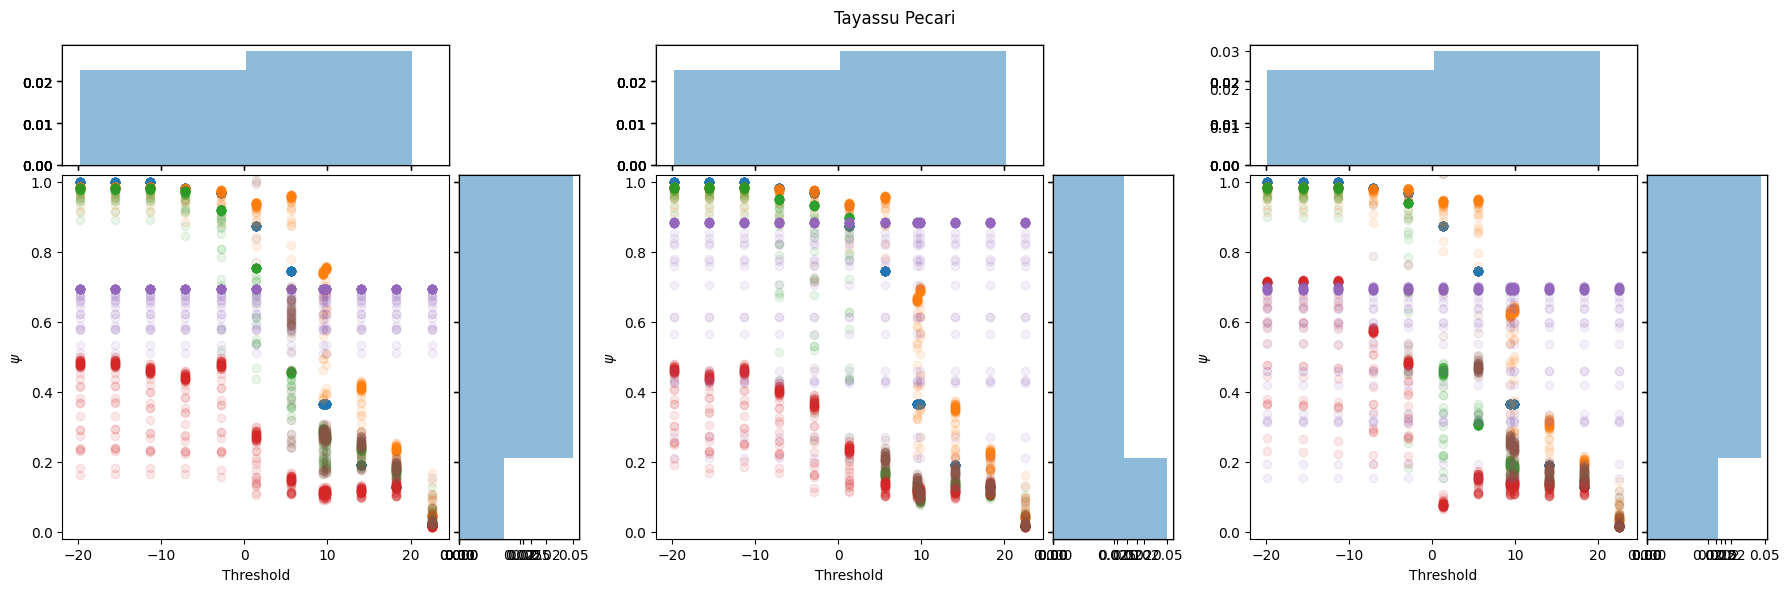

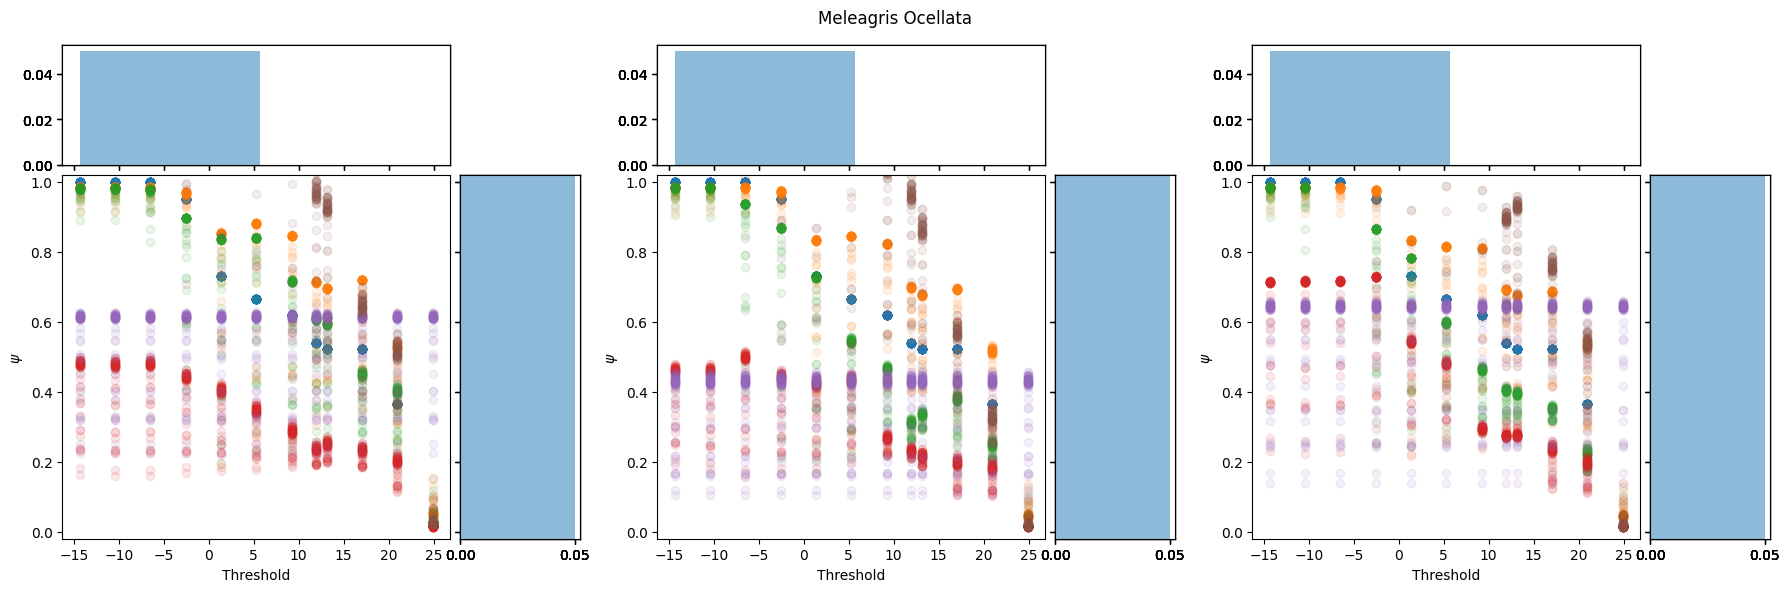

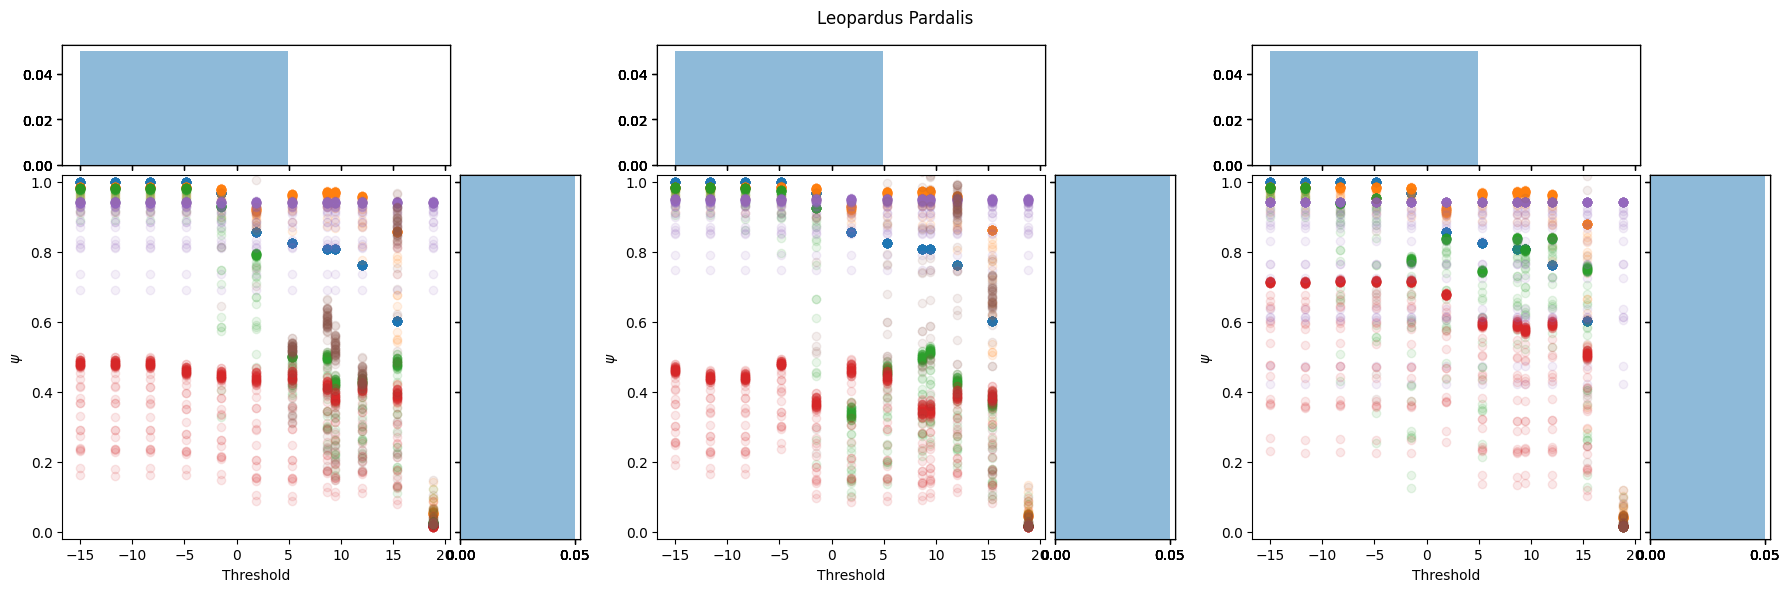

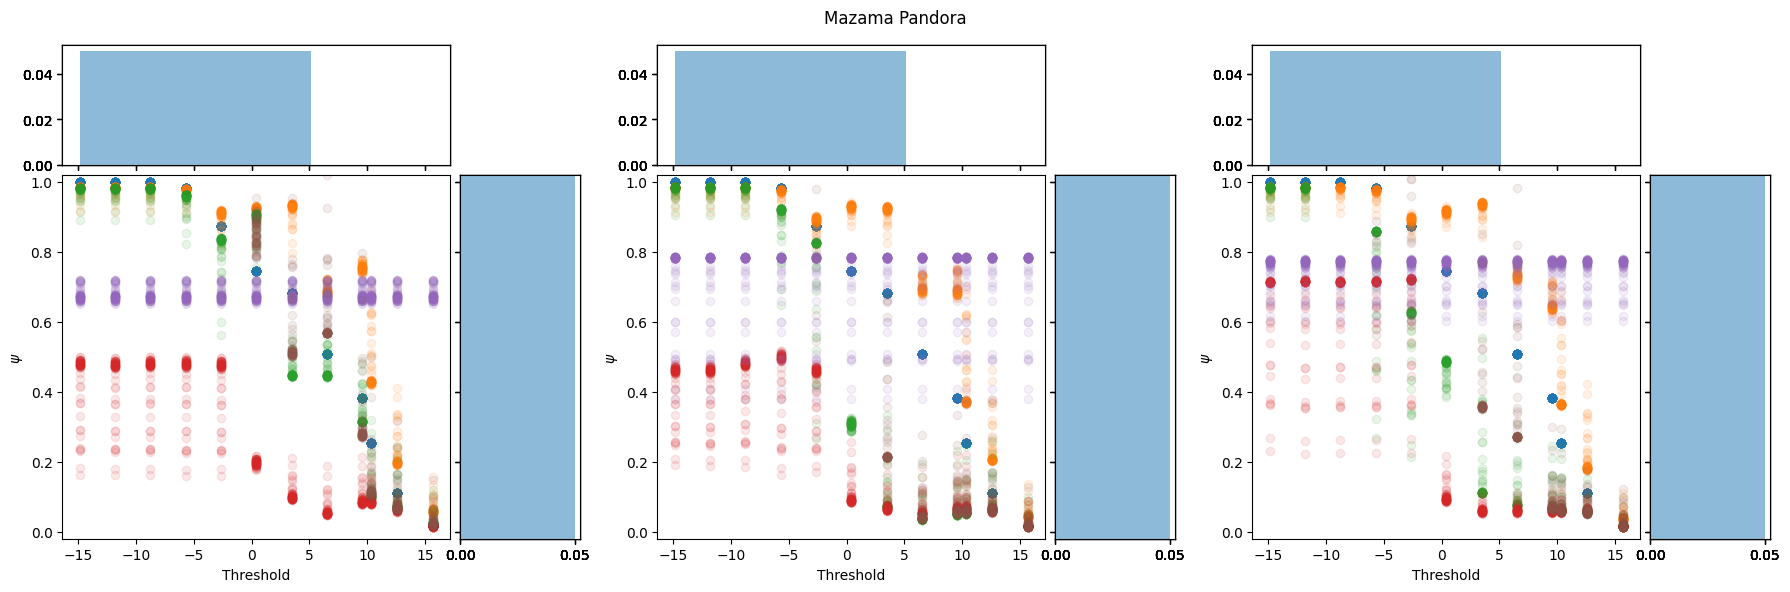

In [7]:
figs = []
for species in df["species"].unique():
    fig, axes = plt.subplots(1, df["Discretisation"].nunique(), figsize=(18, 6)); figs.append(fig)
    for discretisation, ax in zip(df["Discretisation"].unique(), axes):
        mask_species_discretization = (df["species"] == species) & (df["Discretisation"] == discretisation)
        for model in df["Model"].unique():
            mask_sampled = (df["Model"] == model) & (df["species"] == species) & (df["Discretisation"] == discretisation)
            mask = mask_sampled & (df["threshold_type"] != "gt") & (df["threshold_type"] != "topn")
            thresholds = sorted(df[mask]["threshold"].unique())

            # the scatter plot:
            x = df[mask]["threshold"]
            y = df[mask]["Predicted"]
            ax.scatter(x, y, alpha=0.1, label=model)

            ax.set_xlabel("Threshold")
            ax.set_ylabel(r"$\psi$")

            # Set aspect of the main Axes.
            # ax.set_aspect(1.)
            ax.set_ylim(0 - eps, 1 + eps)

            # create new Axes on the right and on the top of the current Axes
            divider = make_axes_locatable(ax)
            # below height and pad are in inches
            ax_histx = divider.append_axes("top", 1.2, pad=0.1, sharex=ax)
            ax_histy = divider.append_axes("right", 1.2, pad=0.1, sharey=ax)

            # make some labels invisible
            ax_histx.xaxis.set_tick_params(labelbottom=False)
            ax_histy.yaxis.set_tick_params(labelleft=False)

            if len(x) > 0:
                bins = np.arange(x.min(), x.max(), 20)
                ax_histx.hist(x, bins=bins, density=True, alpha=0.5, label=model)
                ax_histy.hist(y, bins=bins, density=True, alpha=0.5, label=model, orientation='horizontal')
    fig.suptitle(species.title().replace("_", " "))
    fig.tight_layout()
plt.show()
for fig, species in zip(figs, df["species"].unique()):
    os.makedirs("figures_v3/scatter", exist_ok=True)
    fig.savefig(f"figures_v3/scatter/{species}.pdf", bbox_inches="tight", transparent=True)
    fig.clear()

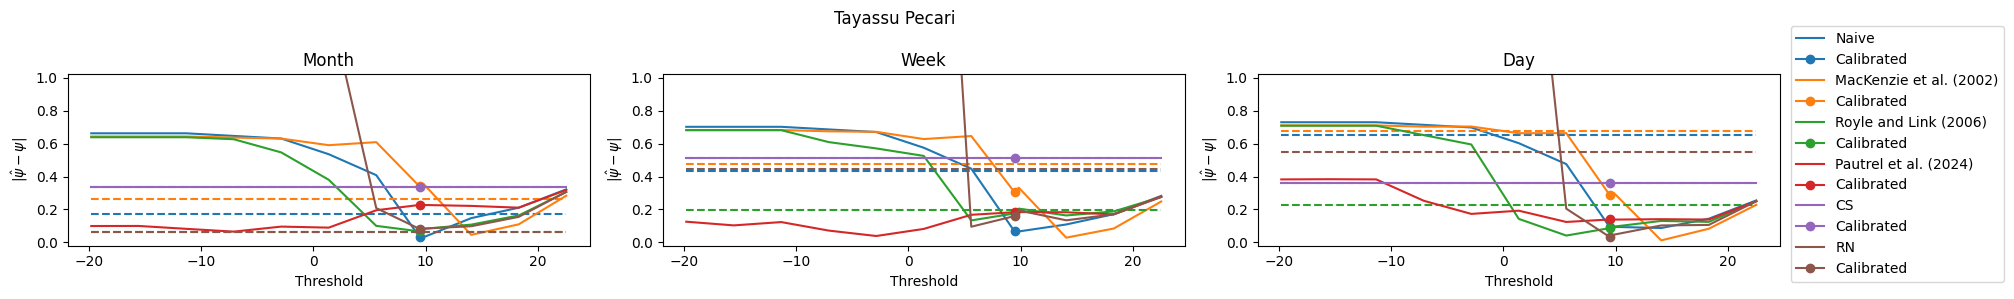

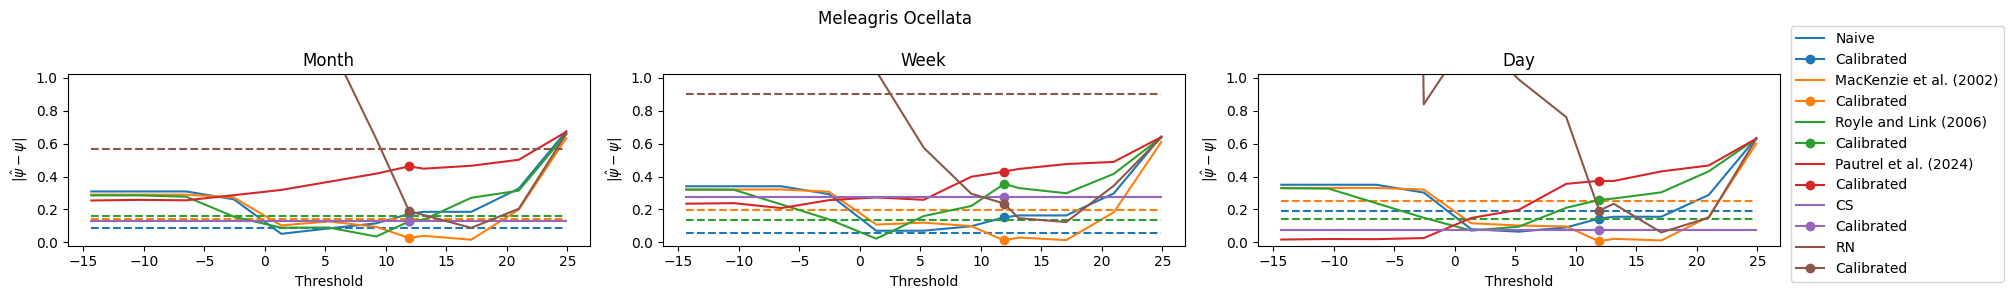

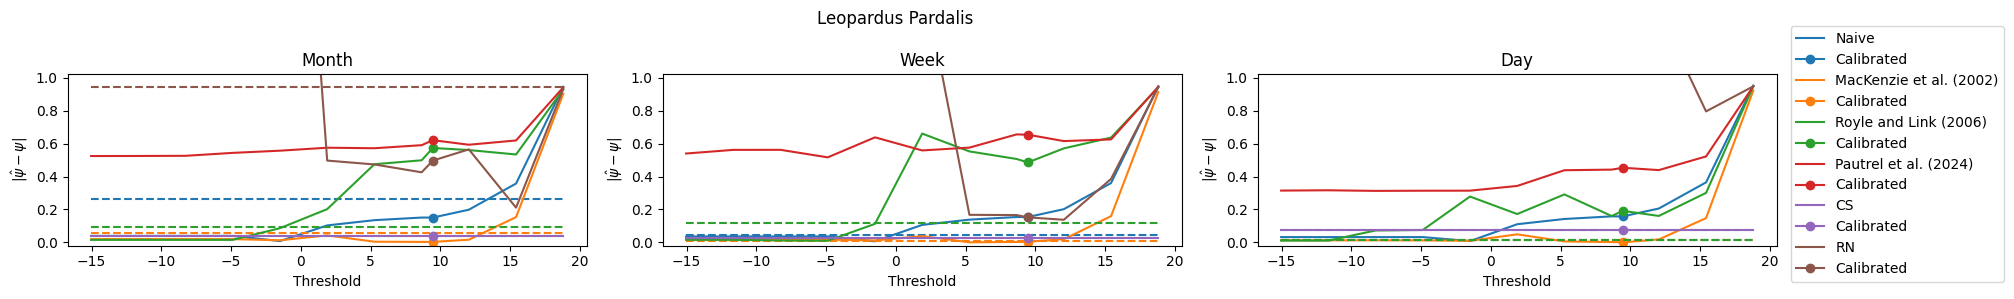

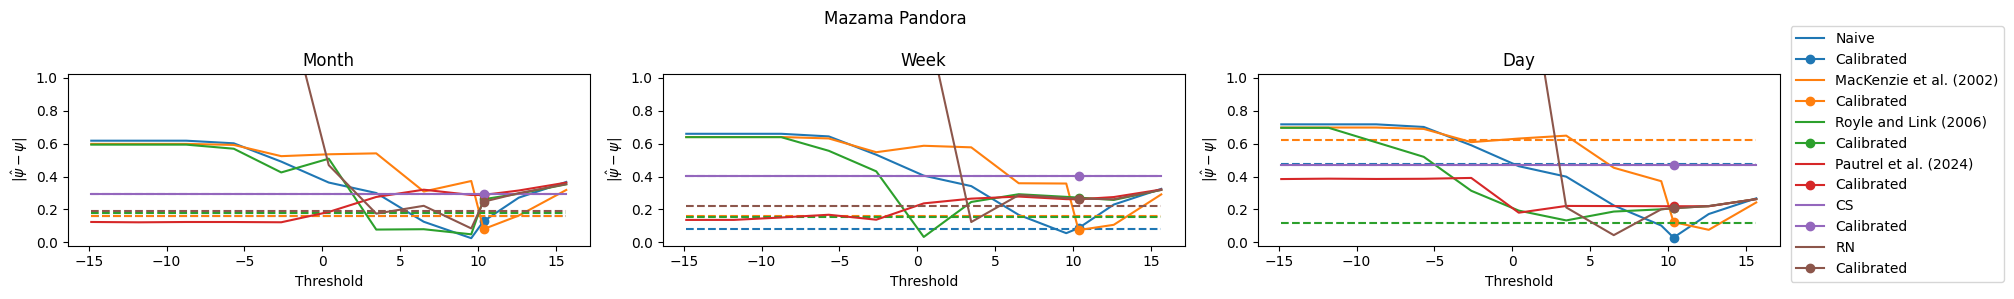

In [8]:
figs = []
for species in df["species"].unique():
    fig, axes = plt.subplots(1, df["Discretisation"].nunique(), figsize=(18, 3)); figs.append(fig)
    for discretisation, ax in zip(df["Discretisation"].unique(), axes):
        mask_species_discretization = (df["species"] == species) & (df["Discretisation"] == discretisation)
        for model in df["Model"].unique():
            mask_sampled = (df["Model"] == model) & (df["species"] == species) & (df["Discretisation"] == discretisation)
            mask = mask_sampled & (df["threshold_type"] != "gt")
            thresholds = sorted(df[mask]["threshold"].unique())
            abs_gt_error = []
            calibrated_abs_gt_error = float("NaN")
            for threshold in thresholds:
                if gt_model is None:
                    gt_mask = mask_sampled & (df["threshold_type"] == "gt")
                else:
                    gt_mask = (df["Model"] == gt_model) & (df["species"] == species) & (df["Discretisation"] == discretisation) & (df["threshold_type"] == "gt")
                pred_mask = mask_sampled & ((df["threshold"] == threshold) if ~np.isnan(threshold) else (np.isnan(df["threshold"]) & (df["threshold_type"] == "topn"))) & (df["threshold_type"] != "gt")
                if gt_mask.sum() != n_sites or pred_mask.sum() != n_sites:
                    abs_gt_error_threshold = []
                else:
                    gt_error_threshold = (df[gt_mask]["Predicted"].to_numpy() - df[pred_mask]["Predicted"].to_numpy())
                    abs_gt_error_threshold = np.abs(gt_error_threshold)
                abs_gt_error.append(np.mean(abs_gt_error_threshold))
                if (df[mask_sampled & (df["threshold_type"] == "calibrated")]["threshold"] == threshold).all():
                    calibrated_abs_gt_error = np.mean(abs_gt_error_threshold)
            if mask.sum() == 0:
                continue
            thresholds = np.array(thresholds)
            abs_gt_error = np.array(abs_gt_error)
            p = ax.plot(thresholds[np.isfinite(thresholds)], abs_gt_error[np.isfinite(thresholds)], label=model_labels.get(model, model))
            ax.plot(thresholds[np.isfinite(thresholds)], [abs_gt_error[np.isnan(thresholds)]] * np.isfinite(thresholds).sum(), linestyle="dashed", color=p[0].get_color())
            ax.set_xlabel("Threshold")
            ax.set_ylabel(r"$|\hat{\psi} - \psi|$")
            # ax.fill_between(df[mask]["threshold"], df[mask][f"psi_CI{ci}lower"], df[mask][f"psi_CI{ci}upper"], color=p[0].get_color(), alpha=0.1)
            if (mask & (df["threshold_type"] == "calibrated")).sum() > 0:
                ax.plot(df[mask & (df["threshold_type"] == "calibrated")]["threshold"].iloc[0], [calibrated_abs_gt_error], color=p[0].get_color(), marker="o", label="Calibrated")
            # p = ax.plot(df[mask_species_discretization]["threshold"], [df[mask_sampled & (df["threshold_type"] == "gt")]["true_mean_psi"]] * mask_species_discretization.sum(), color=p[0].get_color(), linestyle="dashed", label="Ground Truth Labels")
            ax.set_ylim(0 - eps, 1 + eps)
            ax.set_title(discretisation)
            # ax.legend()
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="center right", bbox_to_anchor=(0.12, 0, 1, 1), bbox_transform=fig.transFigure)
    fig.suptitle(species.title().replace("_", " "))
    fig.tight_layout()
plt.show()
for fig, species in zip(figs, df["species"].unique()):
    os.makedirs("figures_v3/abs_gt_error", exist_ok=True)
    fig.savefig(f"figures_v3/abs_gt_error/{species}.pdf", bbox_inches="tight", transparent=True)
    fig.clear()

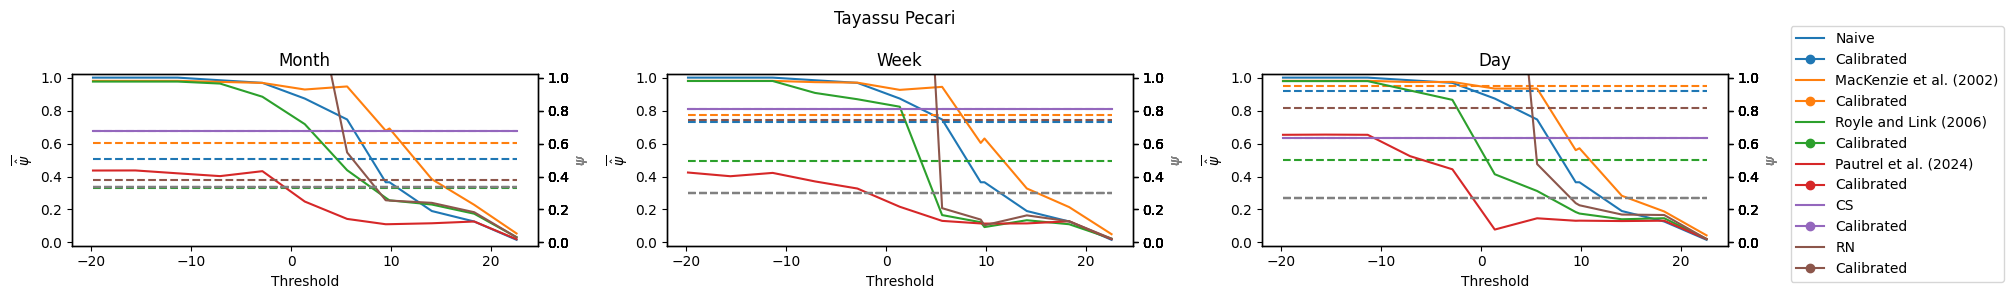

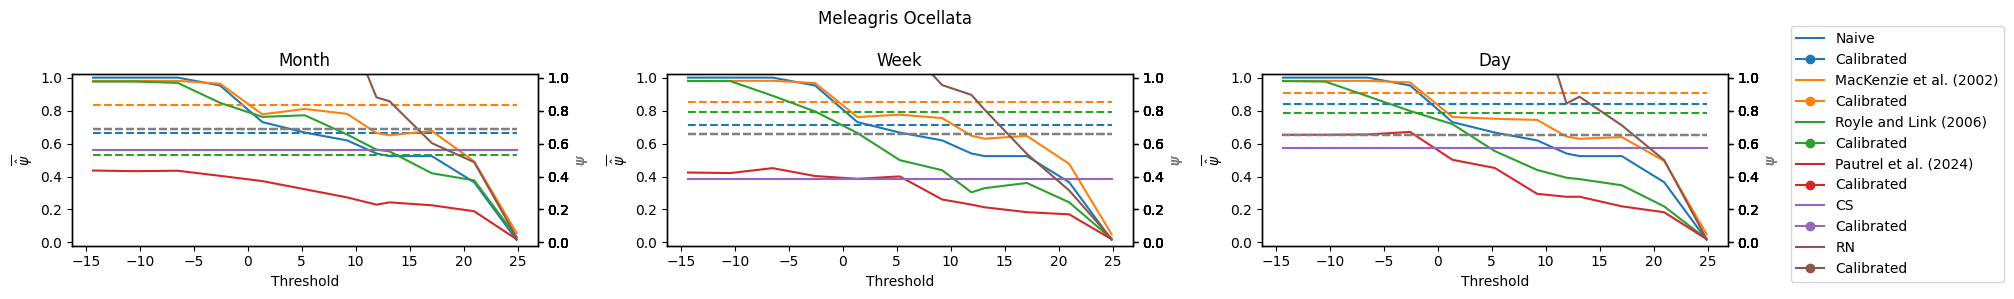

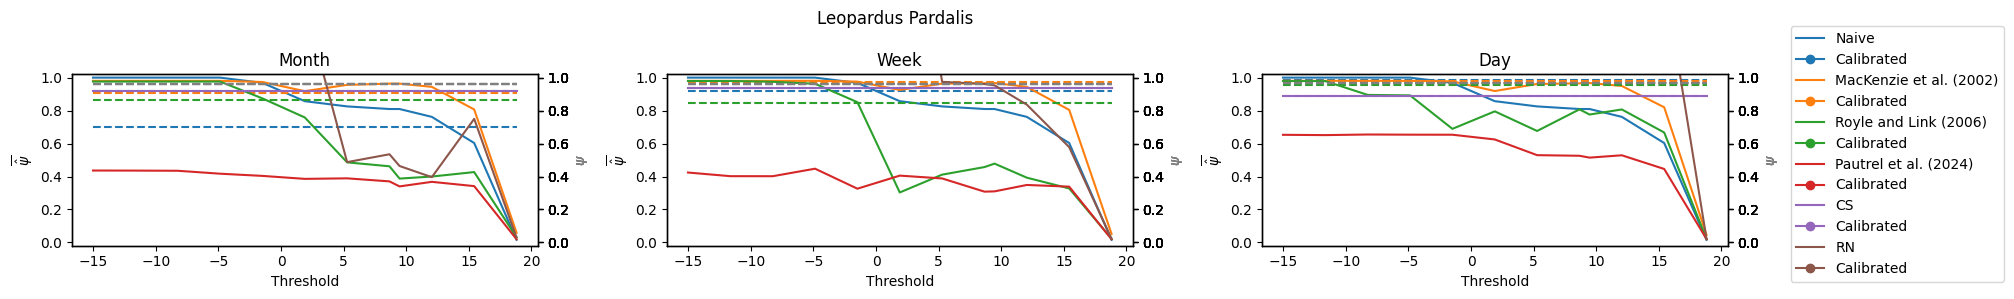

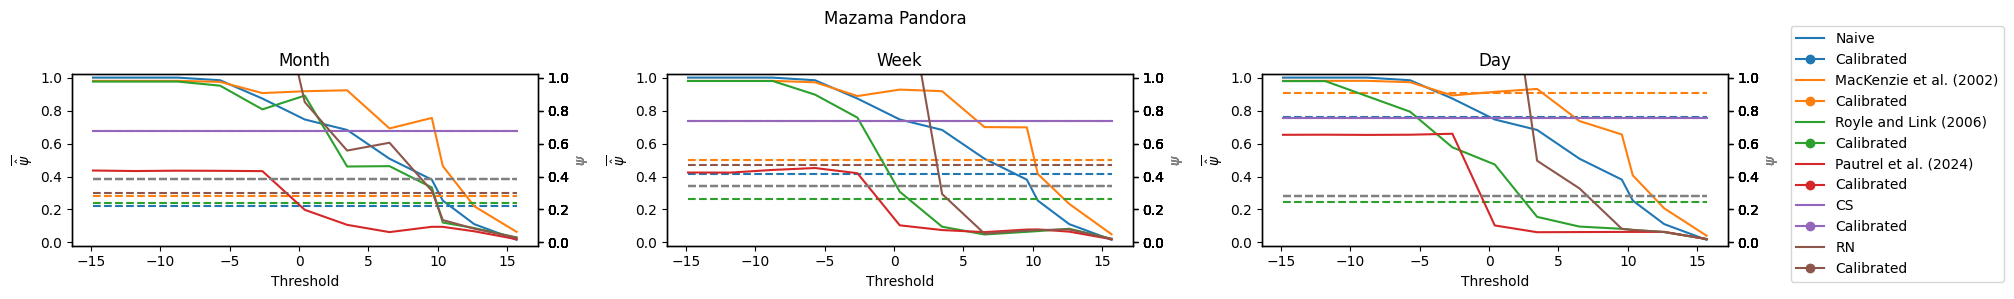

In [9]:
figs = []
for species in df["species"].unique():
    fig, axes = plt.subplots(1, df["Discretisation"].nunique(), figsize=(18, 3)); figs.append(fig)
    for discretisation, ax in zip(df["Discretisation"].unique(), axes):
        mask_species_discretization = (df["species"] == species) & (df["Discretisation"] == discretisation)
        for model in df["Model"].unique():
            mask_sampled = (df["Model"] == model) & (df["species"] == species) & (df["Discretisation"] == discretisation)
            mask = mask_sampled & (df["threshold_type"] != "gt")
            thresholds = sorted(df[mask]["threshold"].unique())
            abs_gt_error = []
            calibrated_abs_gt_error = float("NaN")
            for threshold in thresholds:
                if gt_model is None:
                    gt_mask = mask_sampled & (df["threshold_type"] == "gt")
                else:
                    gt_mask = (df["Model"] == gt_model) & (df["species"] == species) & (df["Discretisation"] == discretisation) & (df["threshold_type"] == "gt")
                pred_mask = mask_sampled & ((df["threshold"] == threshold) if ~np.isnan(threshold) else (np.isnan(df["threshold"]) & (df["threshold_type"] == "topn"))) & (df["threshold_type"] != "gt")
                if gt_mask.sum() != n_sites or pred_mask.sum() != n_sites:
                    abs_gt_error_threshold = []
                else:
                    gt_error_threshold = df[pred_mask]["Predicted"].to_numpy()
                    gt = df[gt_mask]["Predicted"].to_numpy().mean()
                    abs_gt_error_threshold = np.abs(gt_error_threshold)
                abs_gt_error.append(np.mean(abs_gt_error_threshold))
                if (df[mask_sampled & (df["threshold_type"] == "sampled")]["threshold"] == threshold).all():
                    calibrated_abs_gt_error = np.mean(abs_gt_error_threshold)
            if mask.sum() == 0:
                continue
            thresholds = np.array(thresholds)
            abs_gt_error = np.array(abs_gt_error)
            p = ax.plot(thresholds[np.isfinite(thresholds)], abs_gt_error[np.isfinite(thresholds)], label=model_labels.get(model, model))
            ax.plot(thresholds[np.isfinite(thresholds)], [abs_gt_error[np.isnan(thresholds)]] * np.isfinite(thresholds).sum(), linestyle="dashed", color=p[0].get_color())
            ax2 = ax.twinx()
            ax2.plot(thresholds[np.isfinite(thresholds)], [gt] * len(thresholds[np.isfinite(thresholds)]), linestyle="dashed", color="gray")
            ax.set_xlabel("Threshold")
            ax.set_ylabel(r"$\overline{\hat{\psi}}$")
            ax2.set_ylabel(r"$\psi$", color="gray")
            # ax.fill_between(df[mask]["threshold"], df[mask][f"psi_CI{ci}lower"], df[mask][f"psi_CI{ci}upper"], color=p[0].get_color(), alpha=0.1)
            if (mask & (df["threshold_type"] == "sampled")).sum() > 0:
                ax.plot(df[mask & (df["threshold_type"] == "sampled")]["threshold"].iloc[0], [calibrated_abs_gt_error], color=p[0].get_color(), marker="o", label="Calibrated")
            # p = ax.plot(df[mask_species_discretization]["threshold"], [df[mask_sampled & (df["threshold_type"] == "gt")]["true_mean_psi"]] * mask_species_discretization.sum(), color=p[0].get_color(), linestyle="dashed", label="Ground Truth Labels")
            ax.set_ylim(0 - eps, 1 + eps)
            ax2.set_ylim(0 - eps, 1 + eps)
            ax.set_title(discretisation)
            # ax.legend()
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="center right", bbox_to_anchor=(0.12, 0, 1, 1), bbox_transform=fig.transFigure)
    fig.suptitle(species.title().replace("_", " "))
    fig.tight_layout()
plt.show()
for fig, species in zip(figs, df["species"].unique()):
    os.makedirs("figures_v3/mean_occ", exist_ok=True)
    fig.savefig(f"figures_v3/mean_occ/{species}.pdf", bbox_inches="tight", transparent=True)
    fig.clear()

In [10]:
model = "BP"
fig, axes = plt.subplots(1, df["species"].nunique(), figsize=(3 * df["species"].nunique(), 3)); figs.append(fig)
for species, ax in zip(df["species"].unique(), axes):
    for discretisation in df["Discretisation"].unique():
        mask_sampled = (df["Model"] == model) & (df["species"] == species) & (df["Discretisation"] == discretisation)
        mask_gt = mask_sampled & (df["threshold_type"] == "gt")
        ax.hist(df[mask_gt]["Predicted"].to_numpy(), bins=np.linspace(0, 1, 10), alpha=0.25, label=discretisation)
        ax.set_title(f"{species.title().replace('_', ' ')}")
        ax.set_xlabel(r"$\hat{\psi}$")
    axes[-1].legend()
fig.savefig(f"figures_v3/aggregration_hists.pdf", bbox_inches="tight", transparent=True)
fig.clear()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1200x300 with 0 Axes>

/tmp/ipykernel_3563816/1085635341.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, df["Discretisation"].nunique(), figsize=(18, 3)); figs.append(fig)


KeyError: 'cov_state_intercept_hdpi_lower_se'

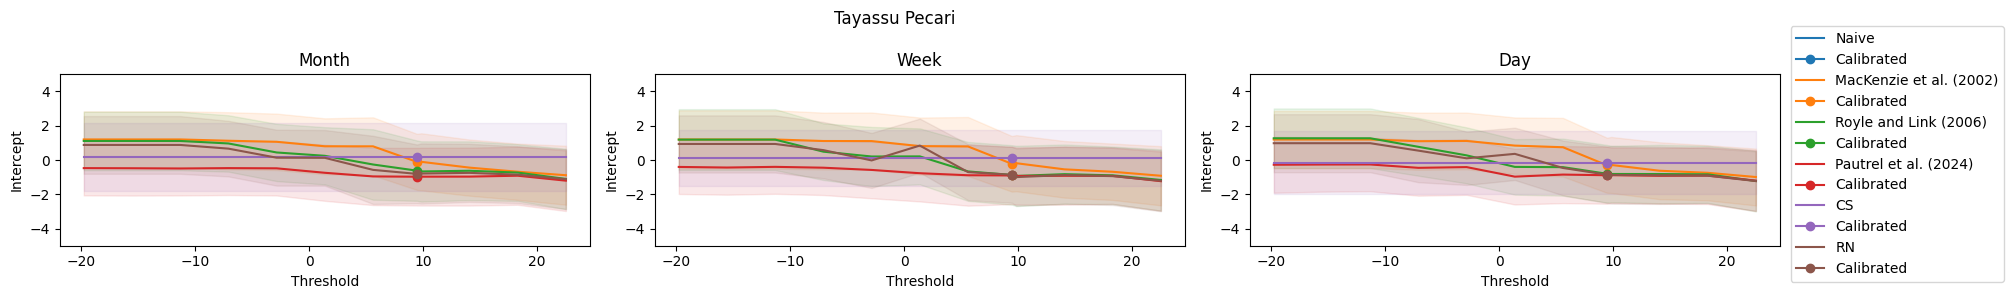

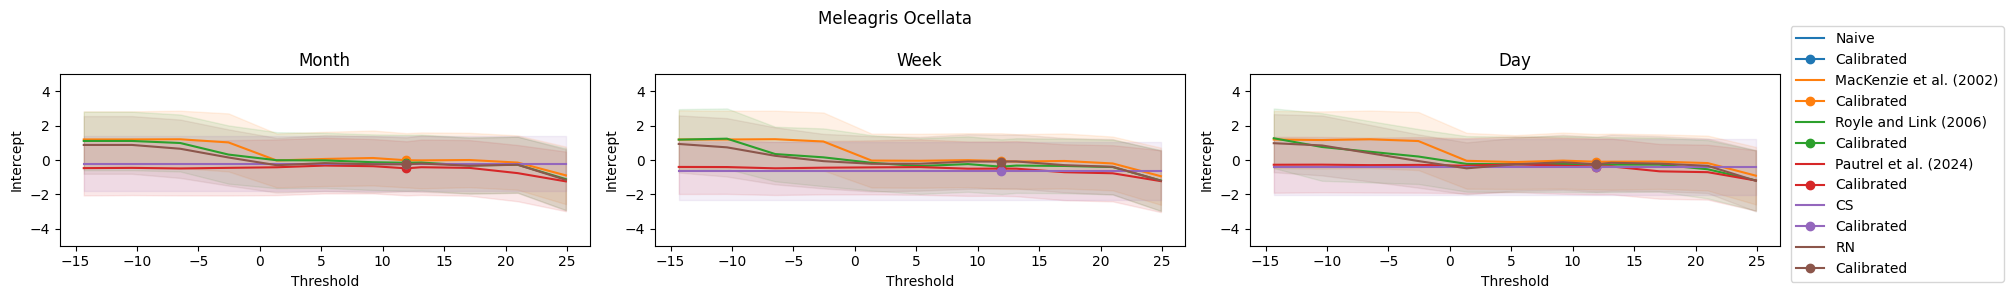

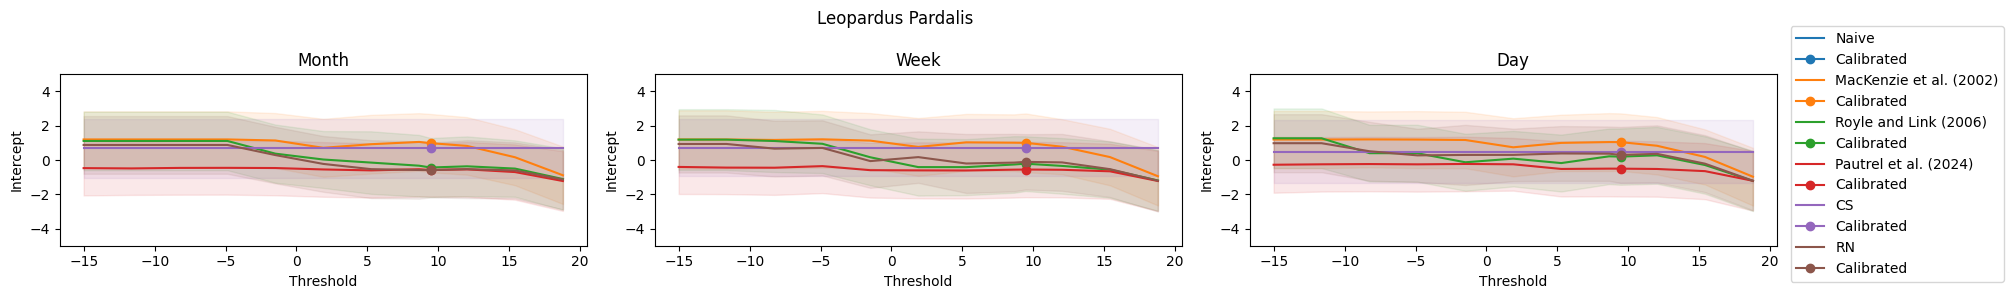

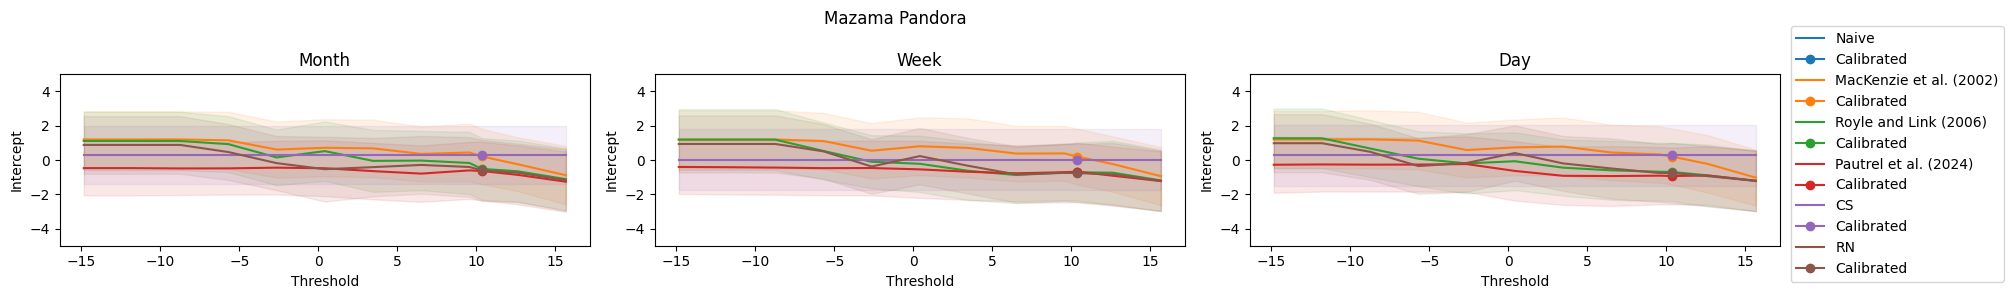

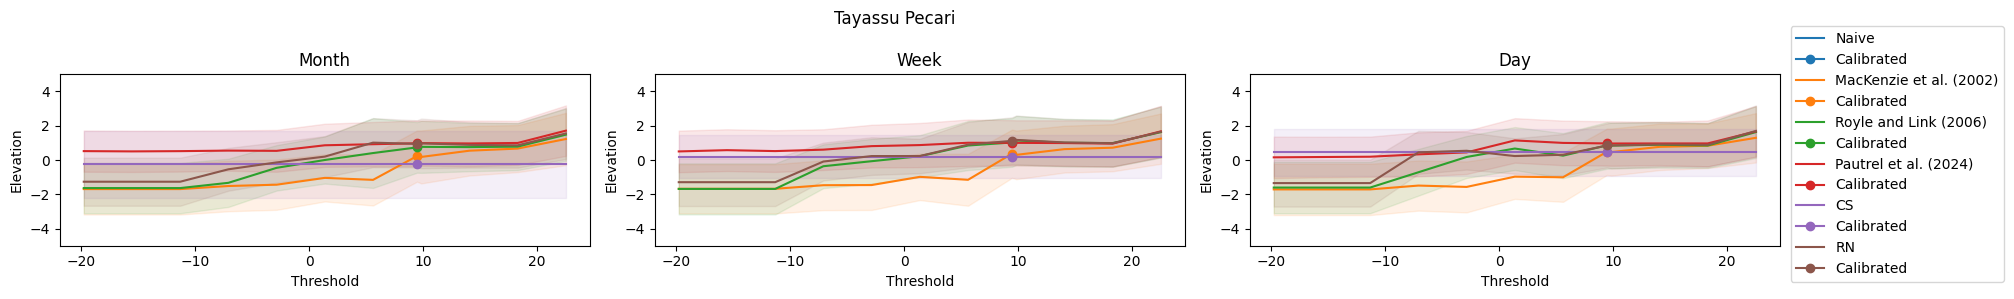

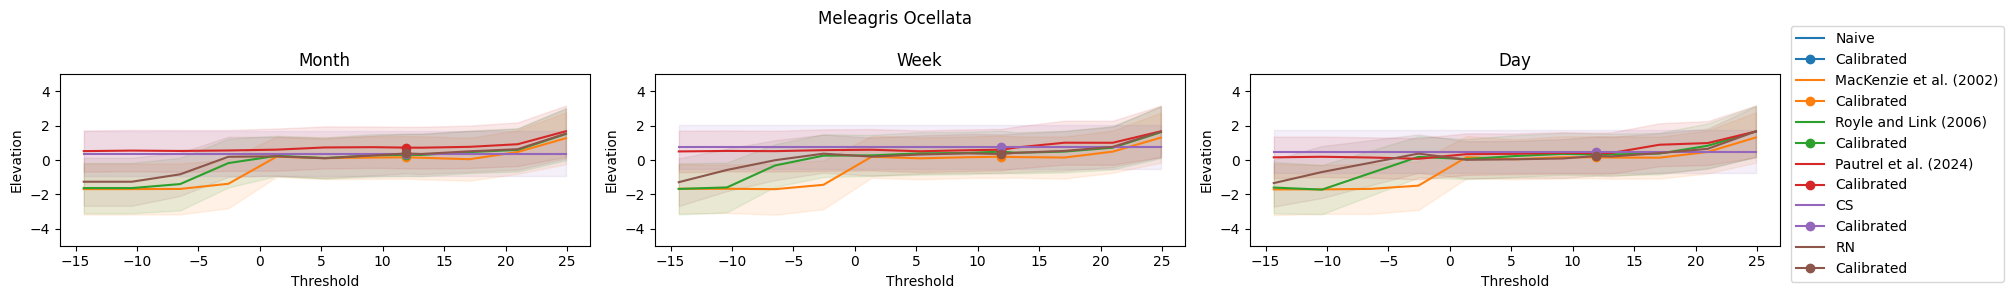

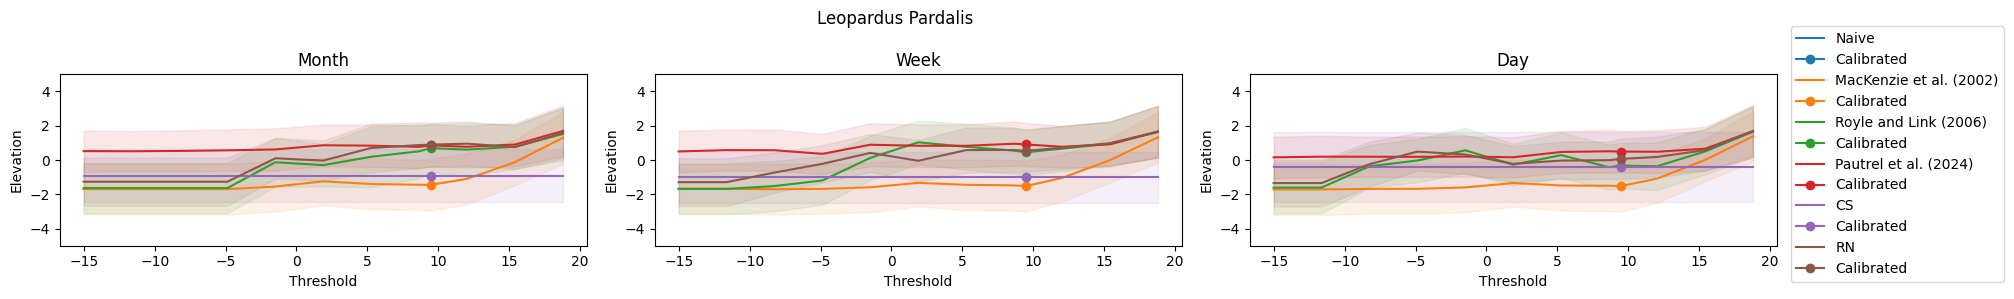

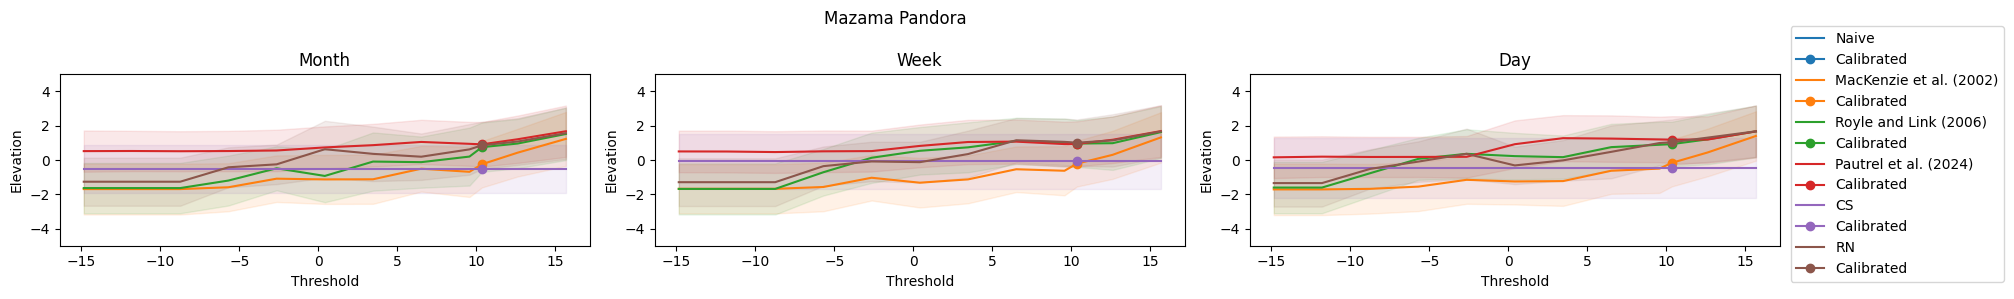

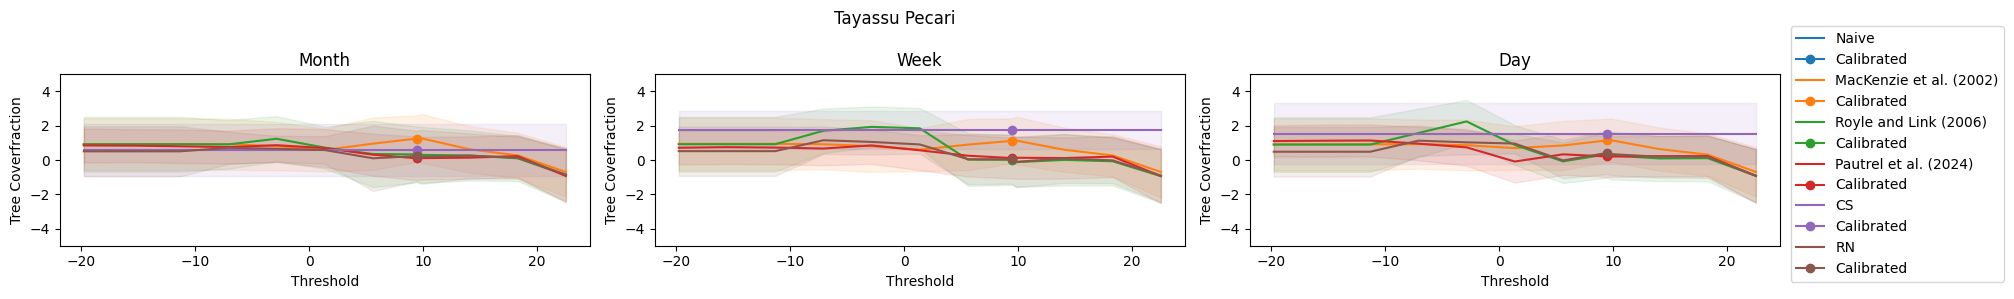

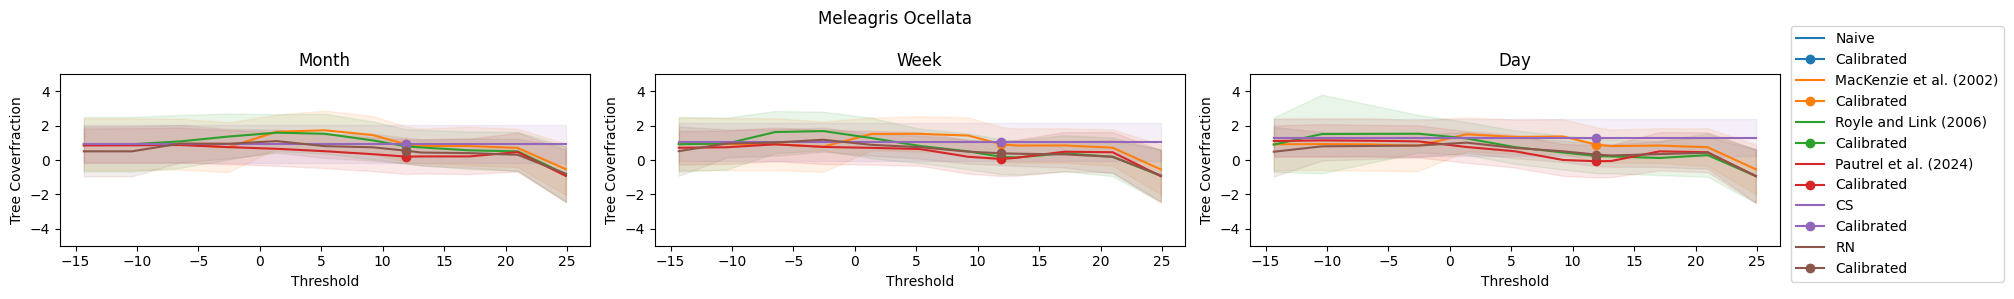

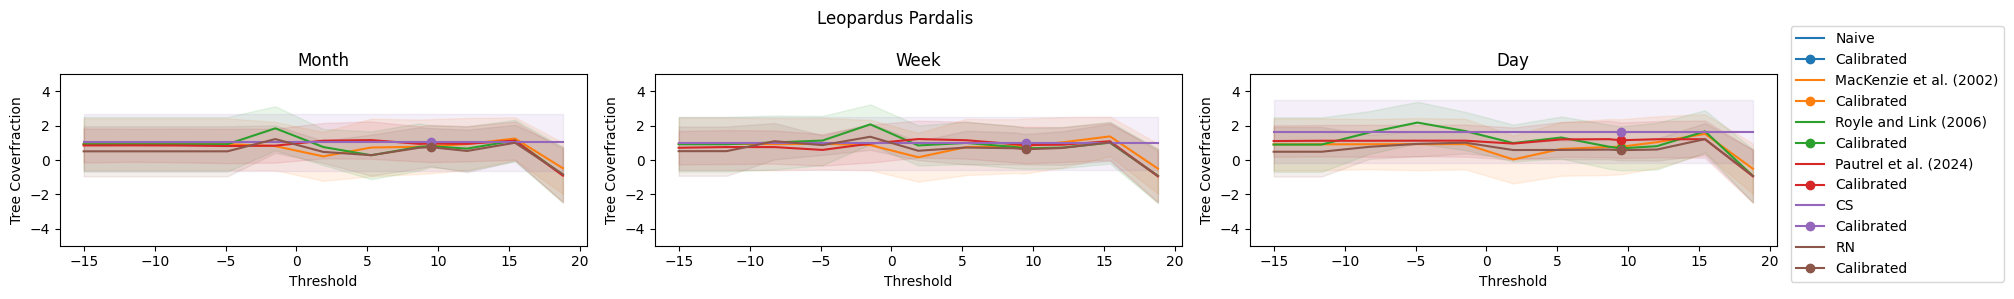

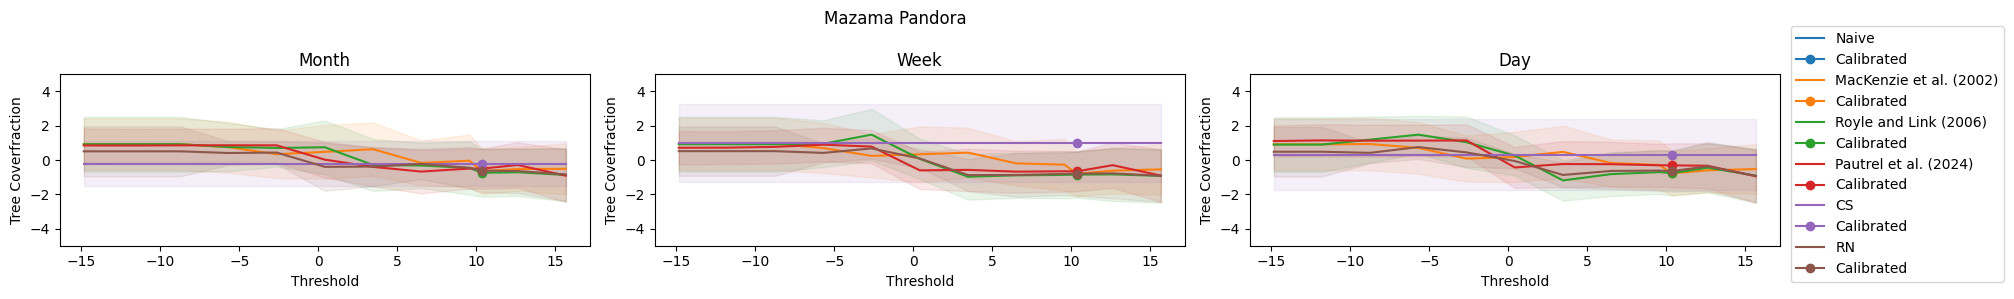

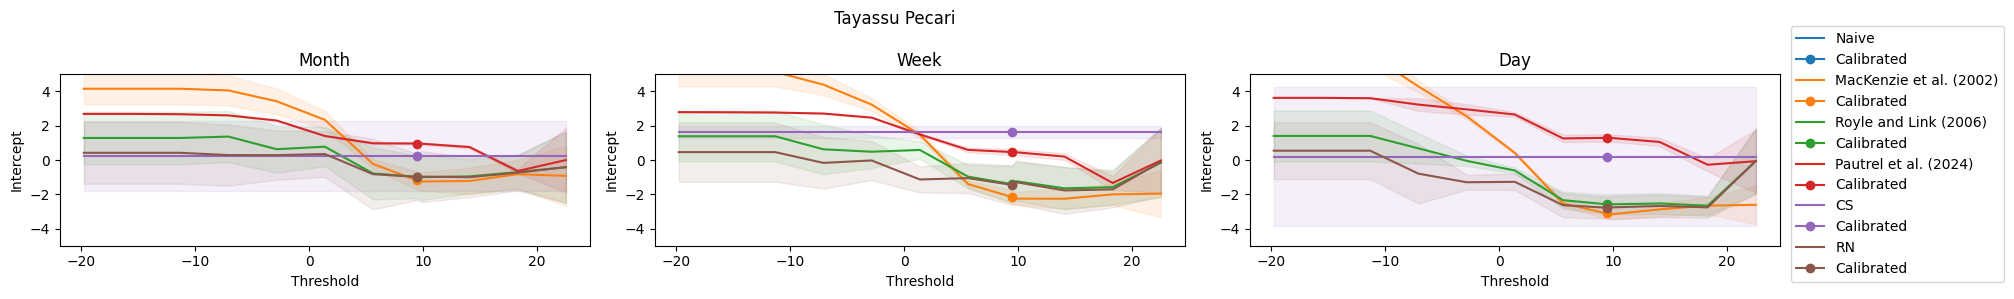

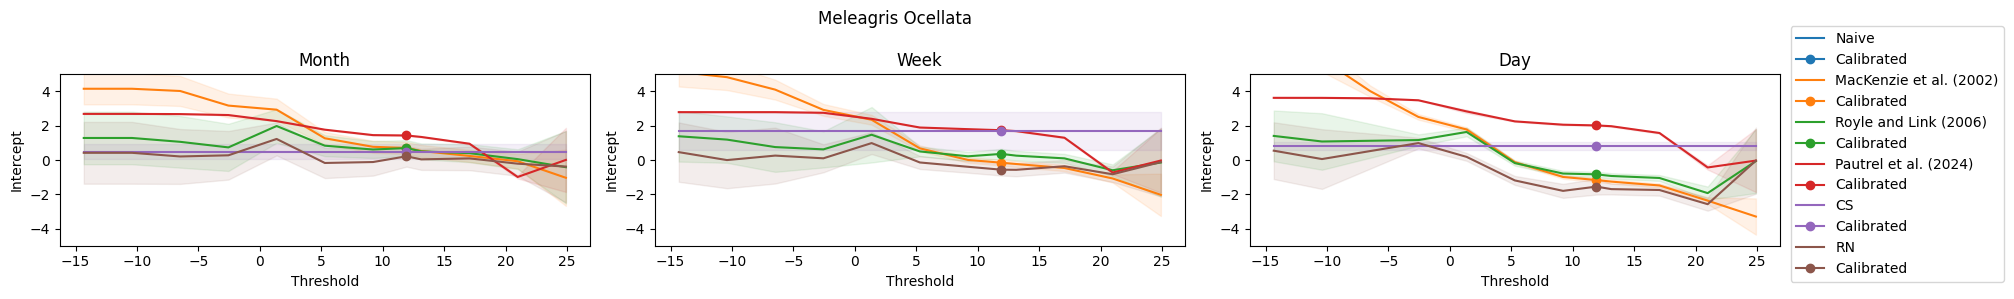

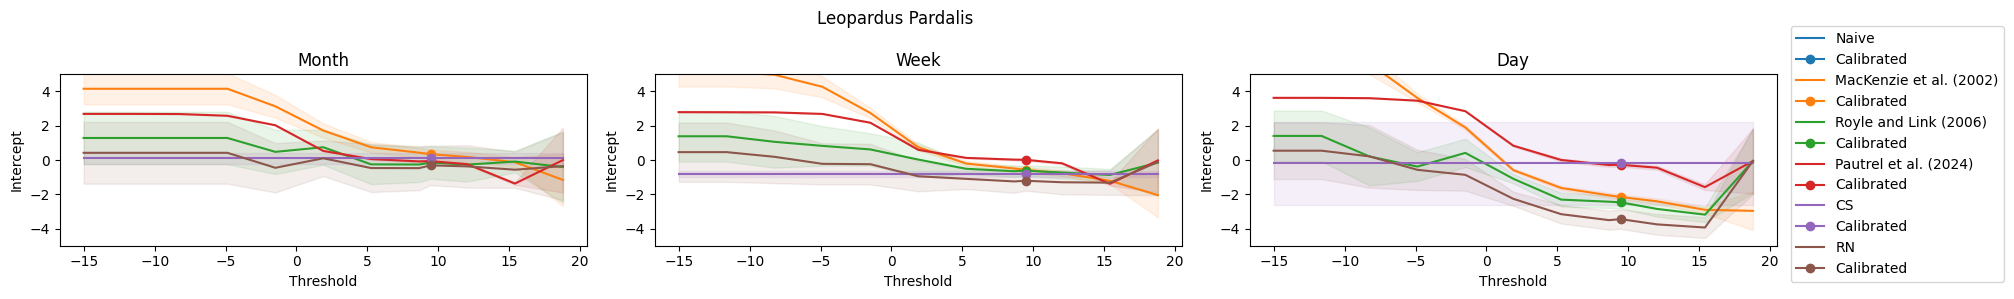

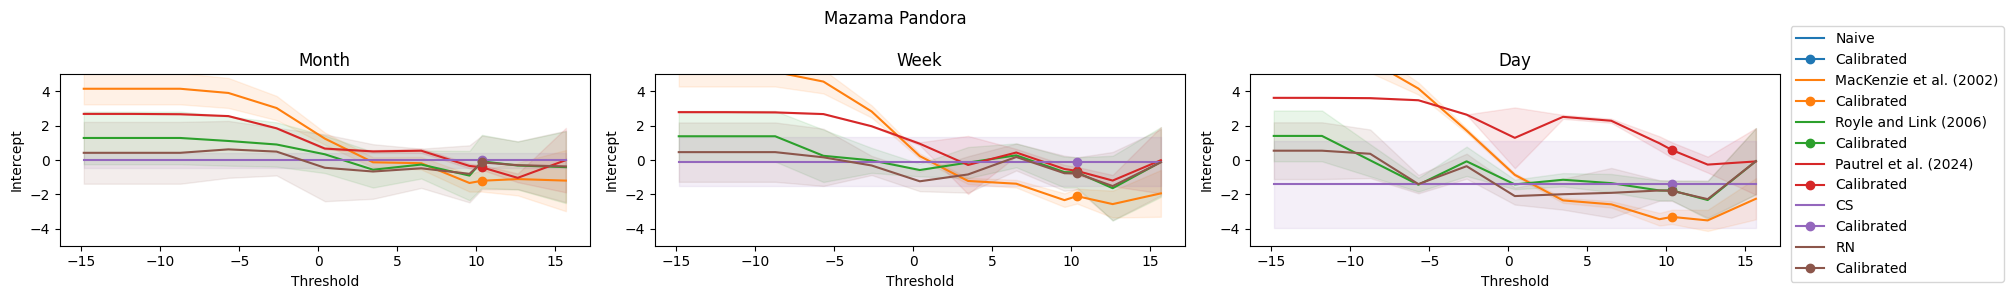

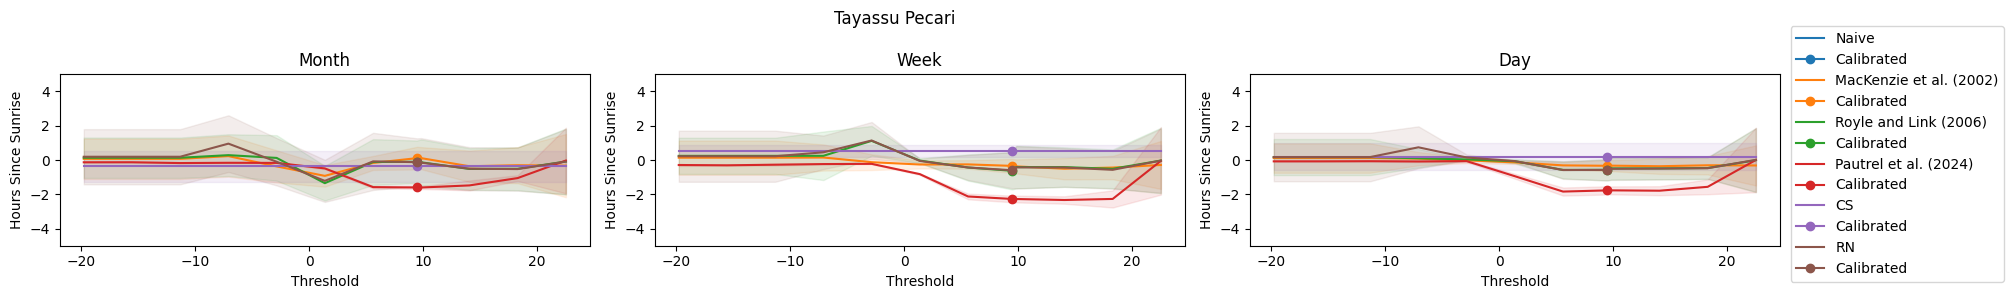

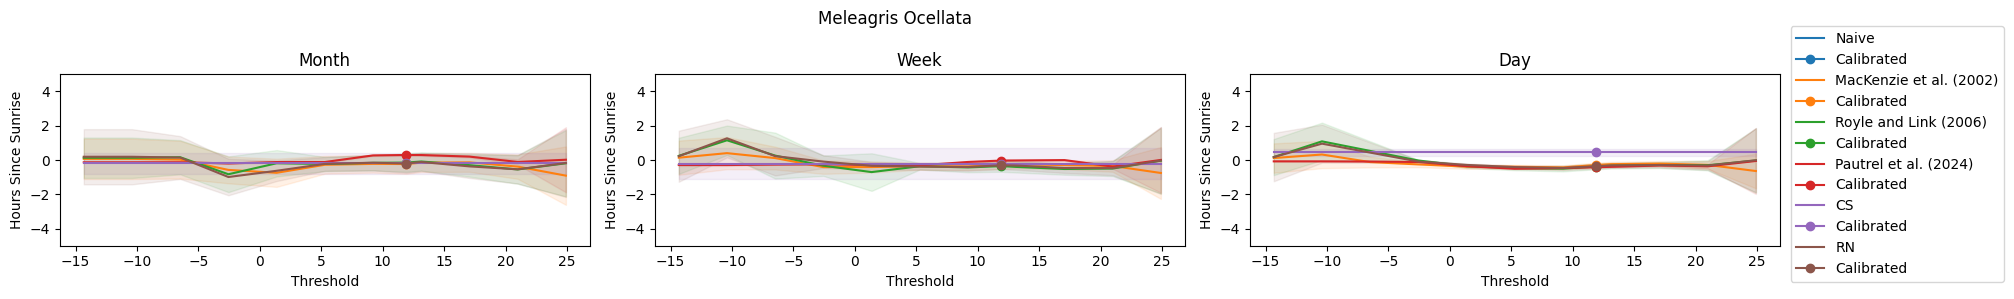

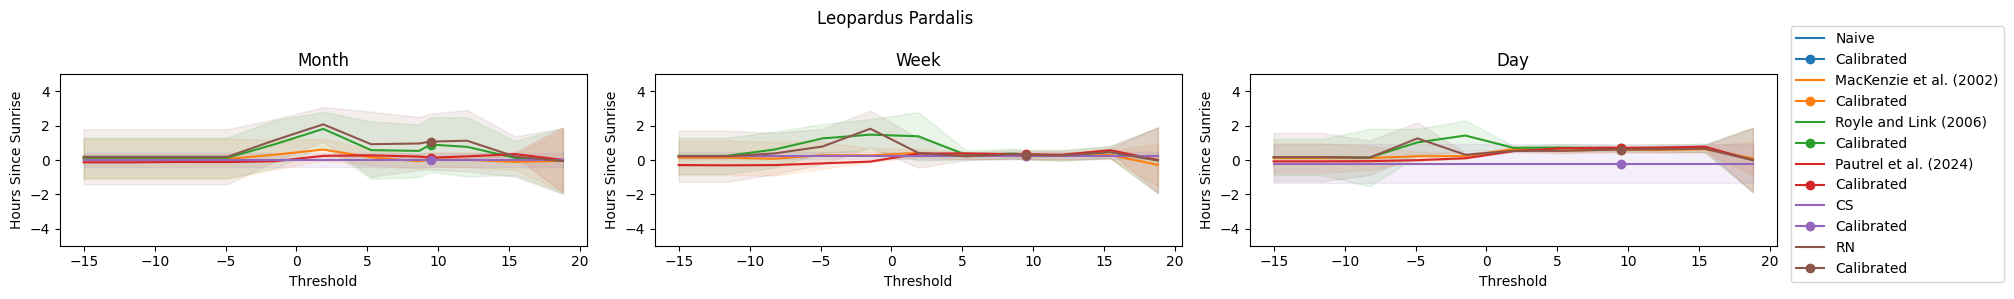

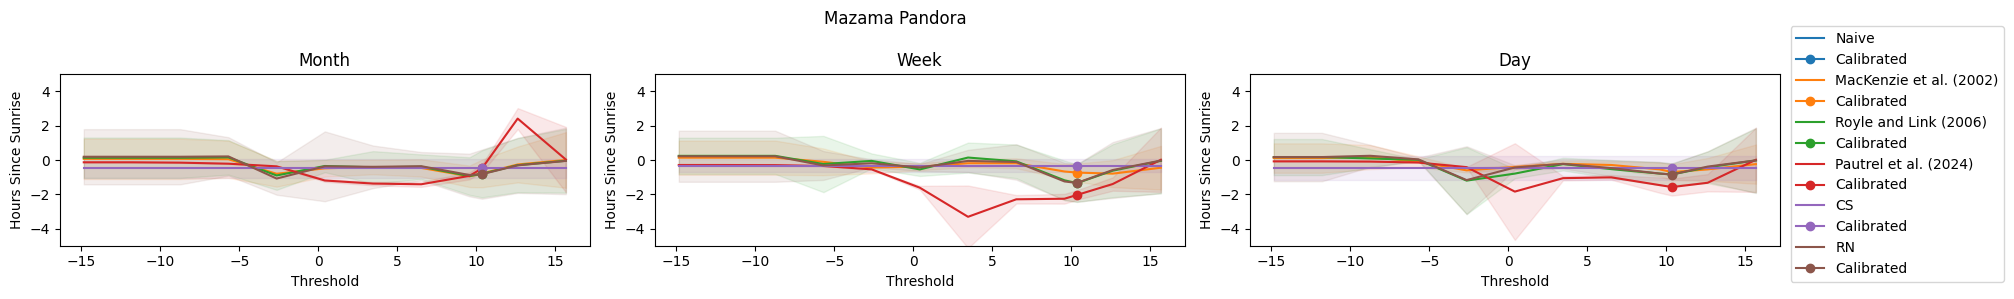

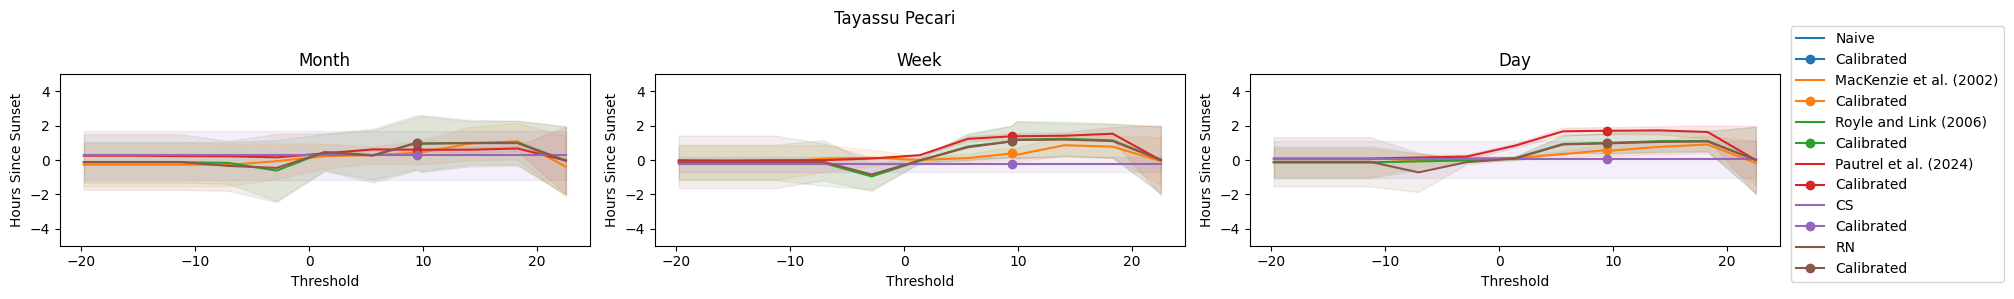

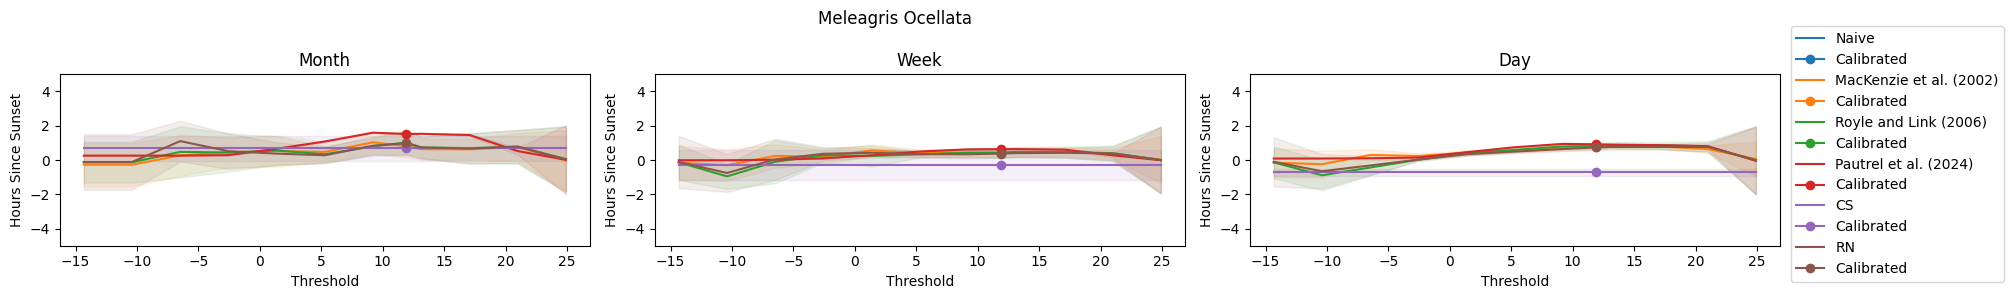

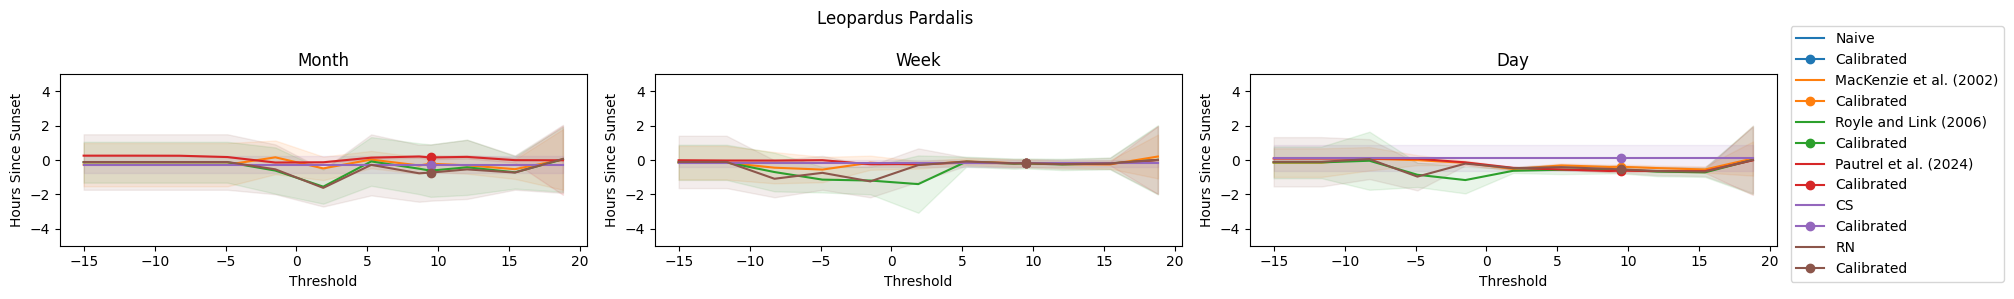

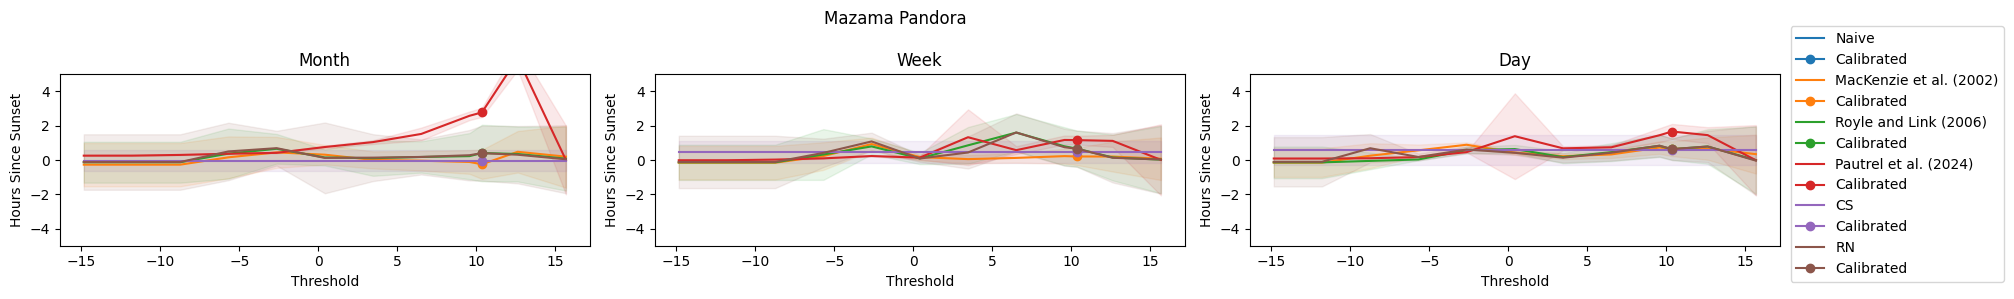

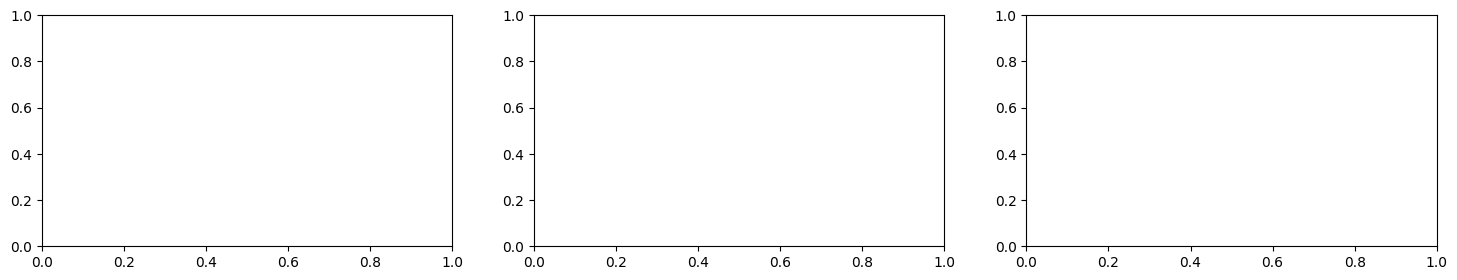

In [11]:
figs = []
for cov in [col for col in df.columns if col.startswith("cov_") and not col.endswith("_se")]:
    for species in df["species"].unique():
        fig, axes = plt.subplots(1, df["Discretisation"].nunique(), figsize=(18, 3)); figs.append(fig)
        for discretisation, ax in zip(df["Discretisation"].unique(), axes):
            mask_species_discretization = (df["species"] == species) & (df["Discretisation"] == discretisation)
            for model in df["Model"].unique():
                mask_sampled = (df["Model"] == model) & (df["species"] == species) & (df["Discretisation"] == discretisation)
                mask = mask_sampled & (df["threshold_type"] != "gt")
                thresholds = sorted(df[mask]["threshold"].unique())
                abs_gt_error = []
                abs_gt_error_se = []
                calibrated_abs_gt_error = float("NaN")
                calibrated_abs_gt_error_se = float("NaN")
                for threshold in thresholds:
                    gt_mask = mask_sampled & (df["threshold_type"] == "gt")
                    pred_mask = mask_sampled & (df["threshold"] == threshold) & (df["threshold_type"] != "gt")
                    abs_gt_error.append(df[pred_mask][cov].mean())
                    abs_gt_error_se.append(df[pred_mask][cov + "_se"].mean())
                    if (df[mask_sampled & (df["threshold_type"] == "calibrated")]["threshold"] == threshold).all():
                        calibrated_abs_gt_error = df[pred_mask][cov].mean()
                        calibrated_abs_gt_error_se = df[pred_mask][cov + "_se"].mean()
                if mask.sum() == 0:
                    continue
                abs_gt_error = np.array(abs_gt_error)
                abs_gt_error_se = np.array(abs_gt_error_se)
                p = ax.plot(thresholds, abs_gt_error, label=model_labels.get(model, model))
                ax.set_xlabel("Threshold")
                ax.set_ylabel(" ".join(cov.split("_")[2:]).title())
                ax.set_ylim([-5, 5])
                ax.fill_between(thresholds, (abs_gt_error - 1.96 * abs_gt_error_se), (abs_gt_error + 1.96 * abs_gt_error_se), color=p[0].get_color(), alpha=0.1)
                if (mask & (df["threshold_type"] == "calibrated")).sum() > 0:
                    ax.plot(df[mask & (df["threshold_type"] == "calibrated")]["threshold"].iloc[0], [calibrated_abs_gt_error], color=p[0].get_color(), marker="o", label="Calibrated")
                # p = ax.plot(df[mask_species_discretization]["threshold"], [df[mask_sampled & (df["threshold_type"] == "gt")]["true_mean_psi"]] * mask_species_discretization.sum(), color=p[0].get_color(), linestyle="dashed", label="Ground Truth Labels")
                # ax.set_ylim(0 - eps, 1 + eps)
                ax.set_title(discretisation)
                # ax.legend()
        handles, labels = axes[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc="center right", bbox_to_anchor=(0.12, 0, 1, 1), bbox_transform=fig.transFigure)
        fig.suptitle(species.title().replace("_", " "))
        fig.tight_layout()
plt.show()
for fig in figs:
    os.makedirs("figures_v3/covs", exist_ok=True)
    fig.savefig(f"figures_v3/covs/{cov}_{species}.pdf", bbox_inches="tight", transparent=True)
    fig.clear()

In [ ]:
figs = []
for species in df["species"].unique():
    fig, axes = plt.subplots(1, df["Discretisation"].nunique(), figsize=(18, 3)); figs.append(fig)
    for discretisation, ax in zip(df["Discretisation"].unique(), axes):
        mask_species_discretization = (df["species"] == species) & (df["Discretisation"] == discretisation)
        for model in df["Model"].unique():
            mask_sampled = (df["Model"] == model) & (df["species"] == species) & (df["Discretisation"] == discretisation)
            mask = mask_sampled & (df["threshold_type"] != "gt")
            thresholds = sorted(df[mask]["threshold"].unique())
            abs_gt_error = []
            fprs = []
            calibrated_abs_gt_error = float("NaN")
            for threshold in thresholds:
                if gt_model is None:
                    gt_mask = mask_sampled & (df["threshold_type"] == "gt")
                else:
                    gt_mask = (df["Model"] == gt_model) & (df["species"] == species) & (df["Discretisation"] == discretisation) & (df["threshold_type"] == "gt")
                pred_mask = mask_sampled & ((df["threshold"] == threshold) if ~np.isnan(threshold) else (np.isnan(df["threshold"]) & (df["threshold_type"] == "topn"))) & (df["threshold_type"] != "gt")
                if gt_mask.sum() != n_sites or pred_mask.sum() != n_sites:
                    abs_gt_error_threshold = []
                else:
                    gt_error_threshold = (df[gt_mask]["Predicted"].to_numpy() - df[pred_mask]["Predicted"].to_numpy())
                    fpr = df[pred_mask]["fpr"].to_numpy().mean()
                    gt = df[gt_mask]["Predicted"].to_numpy().mean()
                    abs_gt_error_threshold = np.abs(gt_error_threshold)
                abs_gt_error.append(np.mean(abs_gt_error_threshold))
                fprs.append(fpr)
                if (df[mask_sampled & (df["threshold_type"] == "sampled")]["threshold"] == threshold).all():
                    calibrated_abs_gt_error = np.mean(abs_gt_error_threshold)
            if mask.sum() == 0:
                continue
            thresholds = np.array(thresholds)
            abs_gt_error = np.array(abs_gt_error)
            fprs = np.array(fprs)
            
            x = abs_gt_error[np.isfinite(thresholds)]
            y = fprs[np.isfinite(thresholds)]

            ax.scatter(x, y)
            ax.set_xlabel(r"$|\hat{\psi} - \psi|$")
            ax.set_ylabel("FPR")
            ax.set_title(discretisation)
            # ax.legend()
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="center right", bbox_to_anchor=(0.12, 0, 1, 1), bbox_transform=fig.transFigure)
    fig.suptitle(species.title().replace("_", " "))
    fig.tight_layout()
plt.show()
for fig, species in zip(figs, df["species"].unique()):
    os.makedirs("figures_v3/fpr_occerr", exist_ok=True)
    fig.savefig(f"figures_v3/fpr_occerr/{species}.pdf", bbox_inches="tight", transparent=True)
    fig.clear()

In [ ]:
# figs = []
# for species in df["species"].unique():
#     fig, axes = plt.subplots(1, df["Discretisation"].nunique(), figsize=(18, 3)); figs.append(fig)
#     for discretisation, ax in zip(df["Discretisation"].unique(), axes):
#         for model in df["Model"].unique():
#             mask_sampled = (df["Model"] == model) & (df["species"] == species) & (df["Discretisation"] == discretisation)
#             mask = mask_sampled & (df["threshold_type"] != "gt")
#             if mask.sum() == 0:
#                 continue
#             p = ax.plot(df[mask]["threshold"], df[mask]["p_PointEstimate"], label=model_labels.get(model, model))
#             ax.set_xlabel("Threshold")
#             ax.set_ylabel("P")
#             # ax.fill_between(df[mask]["threshold"], df[mask][f"p_CI{ci}lower"], df[mask][f"psi_CI{ci}upper"], color=p[0].get_color(), alpha=0.1)
#             p = ax.plot(df[mask]["threshold"], [df[mask_sampled & (df["threshold_type"] == "gt")]["abs_gt_error"]] * mask.sum(), color=p[0].get_color(), linestyle="dashed", label="Ground Truth Labels")
#             ax.set_ylim(0, 1)
#             ax.set_title(discretisation)
#             # ax.legend()
#     handles, labels = axes[0].get_legend_handles_labels()
#     fig.legend(handles, labels, loc="center right", bbox_to_anchor=(0.04, 0, 1, 1), bbox_transform=fig.transFigure)
#     fig.suptitle(species.title().replace("_", " "))
# plt.show()
# for fig in figs:
#     os.makedirs("figures_v3/p", exist_ok=True)
#     fig.savefig(f"figures_v3/p/{species}.pdf", bbox_inches="tight", transparent=True)
#     fig.clear()

In [ ]:
dfr = pd.read_csv("../data/iwildcam_2022_crops_bioclip_inference_logits_v3.csv")
dfr["datetime"] = pd.to_datetime(dfr["datetime"])
start, end = dfr["datetime"].min(), dfr["datetime"].max()
locs = np.sort(np.random.default_rng(seed=42).choice(dfr["location"].unique(), 10))
fig, axes = plt.subplots(len(locs), 1, figsize=(15, 20))
for location, ax in zip(locs, axes):
    dfr[dfr["location"] == location].hist(column="datetime", bins=100, ax=ax, range=(start, end))
    ax.set_title(f"Site {location}")
    ax.set_ylabel("Observations")
fig.tight_layout()
fig.savefig("figures/site_samples_over_time.pdf", transparent=True, bbox_inches="tight")